In [1]:
import torch
from torchvision import transforms
from IPython.display import display
from utils.loss_function import SaliencyLoss

print("All imports successful")

All imports successful


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from TranSalNet_Res import TranSalNet
model = TranSalNet()
model.load_state_dict(torch.load(r'pretrained_models/TranSalNet_Res.pth', map_location=torch.device('cpu')))

model = model.to(device) 
model.eval()

print("Model imported successfully")

Model imported successfully


torch.Size([1, 1, 288, 384])


/Users/hasinmahmood/opt/miniconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


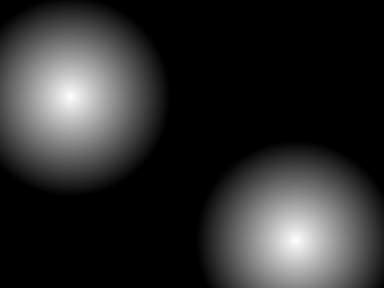

In [3]:
#TARGET TWO CIRCLES
target = torch.zeros(1, 1, 288, 384)

cx1, cy1 = target.shape[2] / 1.2, target.shape[3] / 1.3
cx2, cy2 = target.shape[2] /3, target.shape[2] /4.1 

max_dist1, max_dist2 = 100, 100  # set max distances for both circles

xx, yy = torch.meshgrid(torch.linspace(0, target.shape[2] - 1, target.shape[2]), torch.linspace(0, target.shape[3] - 1, target.shape[3]))
distances1 = torch.sqrt((xx - cx1) ** 2 + (yy - cy1) ** 2)
distances2 = torch.sqrt((xx - cx2) ** 2 + (yy - cy2) ** 2)

values = torch.clamp(1 - distances1 / max_dist1, 0) + torch.clamp(1 - distances2 / max_dist2, 0)  # add the two circle values together

target[0, 0, :, :] = values
print(target.shape)

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)




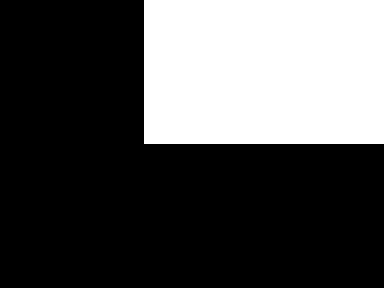

In [4]:
#TARGET CORNER

target = torch.zeros(1, 1, 288, 384)

# Set the top right of the tensor to white
target[:, :, :target.shape[2]//2, target.shape[2]//2:] = 1.0

pic = toPIL(target.squeeze())
display(pic)

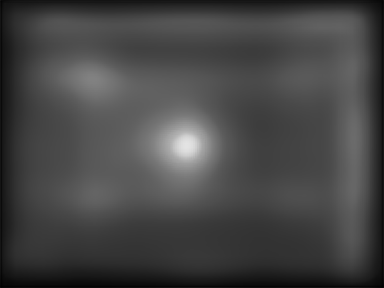

In [5]:
#INIT PATCH FOR BASIC PATCH ATTACK

def init_patch():
    #setting rand_patch to be initialized with 0's or 1's makes a significant difference in the output.
    #both outputs look very different but still acheieve the desired goal
    rand_patch = torch.ones(1,3,288,384)
#     transform = T.ToPILImage()
#     img = transform(rand_patch)
#     img.thumbnail((3200,3200))
#     display(img)
    return rand_patch


first_patch = init_patch()
first_patch = first_patch.type(torch.FloatTensor).to(device)

patch_saliency = model(first_patch)

toPIL = transforms.ToPILImage()
display(toPIL(patch_saliency.squeeze()))

------------------------------------------
tensor([1.1247], grad_fn=<MeanBackward1>)
------------------------------------------
tensor([1.0540], grad_fn=<MeanBackward1>)
------------------------------------------
tensor([1.0089], grad_fn=<MeanBackward1>)
------------------------------------------
tensor([0.8588], grad_fn=<MeanBackward1>)
------------------------------------------
tensor([0.6654], grad_fn=<MeanBackward1>)
------------------------------------------
tensor([0.4975], grad_fn=<MeanBackward1>)


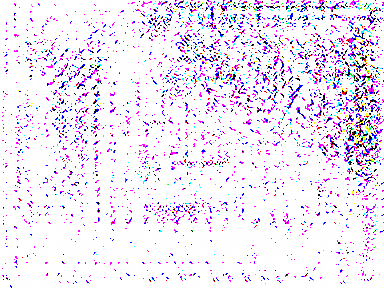

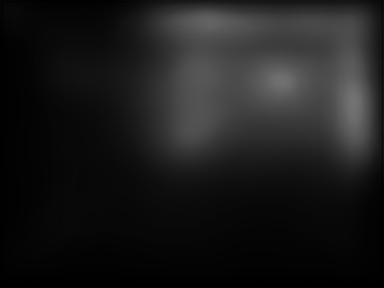

In [6]:
#PERFORM PATCH ATTACK ON TO TARGET SALIENCY TOWARD CERTAIN LOCATIONS
def patch_attack(patch, target_saliency, loss_target):
    #import loss functions
    loss_fn=SaliencyLoss()
    #init loss to be high as for kl div the lower the loss the better
    loss=10

    #continue updating the patch until they are similar enough, determined by a threshold set by you
    while loss_target < loss:

        print('------------------------------------------')
        patch = patch.clone().detach().requires_grad_(True)

        #get saliency map for patch
        out = model(patch)
        loss = loss_fn(out,target_saliency,loss_type='kldiv')
        loss.backward()

        # torch.set_printoptions(profile="default")
        # print(patch.grad)

        #update patch values
        patch = patch - (patch.grad * 0.2)
        print(loss)

    return patch
    
final_patch = patch_attack(first_patch,target, loss_target = 0.5)
display(toPIL(final_patch.squeeze()))

final_patch_saliency = model(final_patch)
display(toPIL(final_patch_saliency.squeeze()))